# Detecting Car plates
* Load images
* load labels VOC format
* scaleup 
* train 
* test

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
main_path = "/content/drive/MyDrive/CarPlatesDetector/"

In [3]:
import zipfile
import os
if not "new_data" in os.listdir(main_path):
  with zipfile.ZipFile(main_path + "new_data.zip", 'r') as zip_ref:
      zip_ref.extractall(main_path)

if not "old_data" in os.listdir(main_path):
  with zipfile.ZipFile(main_path + "old_data.zip", 'r') as zip_ref:
      zip_ref.extractall(main_path)

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2
import os
import glob
from lxml import etree
import random


from datetime import datetime

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

# Constants

In [5]:
IMAGE_SIZE = 224
random.seed(4)
# old case
img_dir = main_path + "old_data/result_images_512/"
xml_dir = main_path + "old_data/Plate_xml_512/"
# new case
img_dir = main_path + "new_data/Label_image_800/"
xml_dir = main_path + "new_data/Label_xml_800/"
data_path = os.path.join(img_dir,'*jpg')
labels_path=os.path.join(xml_dir,'*xml')


# Load and Prepare data

In [6]:
# import os
# images = os.listdir(main_path + "data/Label_image_800")
# xmls = os.listdir(main_path + "data/Label_xml_800")
# img_names = []
# xml_names = []
# for name in images:
#   img_names.append(name.split(".")[0])
# for name in xmls:
#   xml_names.append(name.split(".")[0])
# for i in img_names:
#   if not i in xml_names:
#     print(i + ".jpg")
# for i in xml_names:
#   if not i in img_names:
#     print(i + ".xml")

In [7]:
def resize_one_label(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
        return [int(xmax), int(ymax), int(xmin), int(ymin)]

def resize_labels(f):
    tree = etree.parse(f)
    result = []
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
        result.append(np.array([int(xmax), int(ymax), int(xmin), int(ymin)]))
    return np.array(result)

files = glob.glob(data_path)
files.sort()
#files=random.sample(files, 100)
X=[]
y=[]
for f in tqdm(files):
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_input(img)
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Preprocess images
    
    # img_transf = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # img_transf[:,:,2] = cv2.equalizeHist(img_transf[:,:,2])
    # img = cv2.cvtColor(img_transf, cv2.COLOR_HSV2RGB)
    # #########################
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    # load labels
    fxml=xml_dir+(os.path.basename(f).split("jpg"))[0]+"xml"
    # y.append(resize_one_label(fxml))
    y.append(resize_one_label(fxml))

100%|██████████| 5209/5209 [02:00<00:00, 43.14it/s]


In [8]:
X=np.array(X)
y=np.array(y)

In [9]:
X.shape,y.shape

((5209, 224, 224, 3), (5209, 4))

In [10]:
# plt.figure(figsize=(16,10))
# for i_car in range(0,20) :
#     plt.subplot(10,3,i_car+1)
#     plt.axis('off')
#     image=X[i_car].copy()
#     lab = y[i_car]
#     image = cv2.rectangle(image,(lab[0],lab[1]),(lab[2],lab[3]),(0, 255, 0),2)
#     plt.title(f"{i_car}")
#     plt.imshow(image)

# Normalize!!!
* coordinates [0,1]
* colorspace  [0,1]

In [11]:
X = X / 255
y = np.divide(y, 255)

In [12]:
def shuffle(matrix, target, test_proportion):
    ratio = int(matrix.shape[0]/test_proportion) #should be int
    X_train = matrix[ratio:,:]
    X_test =  matrix[:ratio,:]
    Y_train = target[ratio:,:]
    Y_test =  target[:ratio,:]
    return X_train, X_test, Y_train, Y_test

X_train, X_test, y_train, y_test = shuffle(X, y, 5)
X_train, X_val, y_train, y_val = shuffle(X_train, y_train, 10)

In [13]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

# Build the CNN based on transfer learning technique

In [14]:
logdir = main_path + "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)


num_classes=4


model = Sequential()
model.add(InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="sigmoid"))
model.add(Dense(64, activation="relu"))
model.add(Dense(num_classes, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 38400)             0         
                                                                 
 dense (Dense)               (None, 128)               4915328   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                        

# Train model 

In [15]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=50, batch_size=5,
                  verbose=1)

Epoch 1/50
751/751 [==============================] - 65s 59ms/step - loss: 0.0080 - accuracy: 0.6874 - val_loss: 0.0068 - val_accuracy: 0.6995
Epoch 2/50
751/751 [==============================] - 41s 54ms/step - loss: 0.0067 - accuracy: 0.7433 - val_loss: 0.0055 - val_accuracy: 0.7644
Epoch 3/50
751/751 [==============================] - 42s 55ms/step - loss: 0.0055 - accuracy: 0.7775 - val_loss: 0.0051 - val_accuracy: 0.7692
Epoch 4/50
751/751 [==============================] - 41s 55ms/step - loss: 0.0048 - accuracy: 0.8137 - val_loss: 0.0054 - val_accuracy: 0.8029
Epoch 5/50
751/751 [==============================] - 43s 57ms/step - loss: 0.0049 - accuracy: 0.8033 - val_loss: 0.0042 - val_accuracy: 0.8245
Epoch 6/50
751/751 [==============================] - 43s 57ms/step - loss: 0.0044 - accuracy: 0.8228 - val_loss: 0.0040 - val_accuracy: 0.8149
Epoch 7/50
751/751 [==============================] - 41s 55ms/step - loss: 0.0044 - accuracy: 0.8249 - val_loss: 0.0040 - val_accuracy:

# Test

In [16]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 85.30%


In [17]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

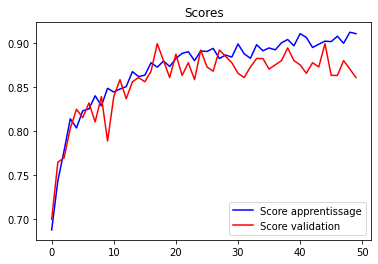

In [18]:
plot_scores(train)

In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(20))
print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

20/20 [==============================] - 9s 347ms/step - loss: 0.0025 - accuracy: 0.8530
Test results 
 Loss: 0.002491061808541417 
 Accuracy 0.8530259132385254


# Detection

In [20]:
y_cnn = model.predict(X_test)

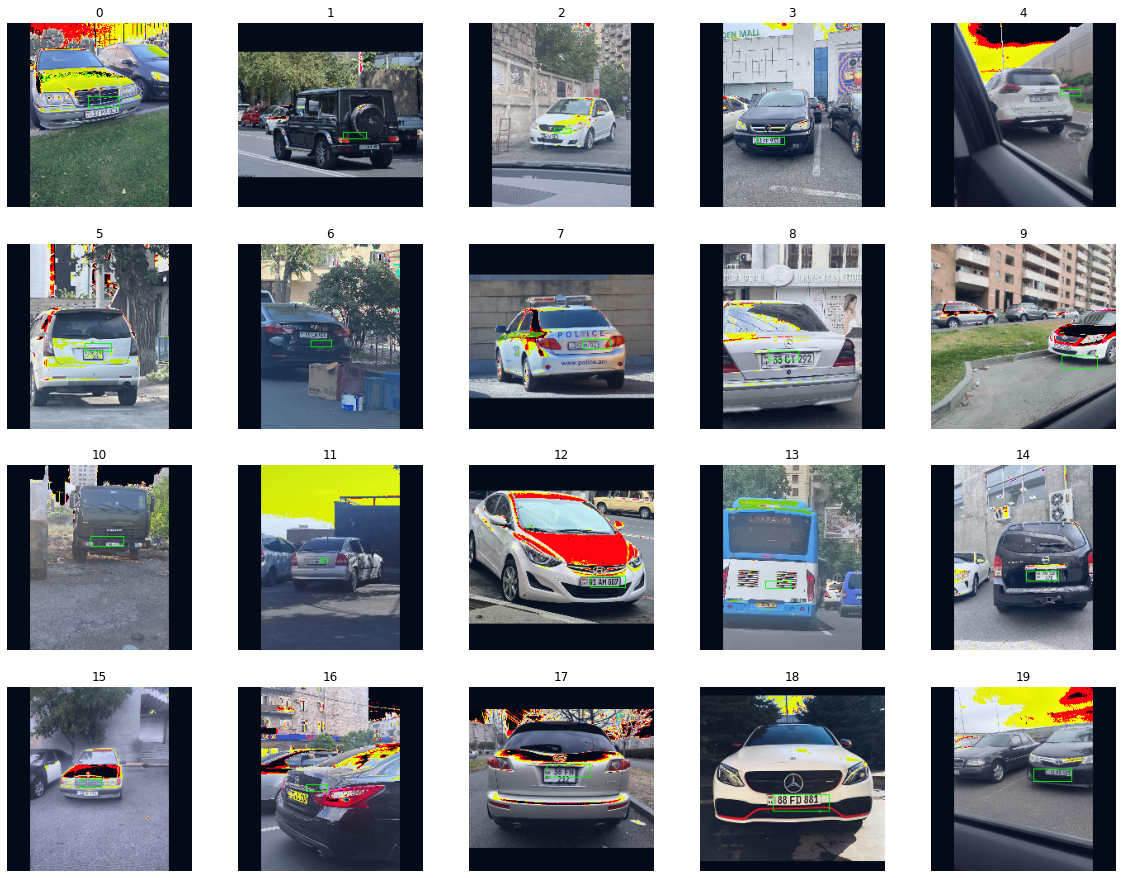

In [24]:
plt.figure(figsize=(20,40))
for i in range(0,20) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image=(X_test[i].copy()*255).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image += 127
    image = cv2.rectangle(image,(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.title(f"{i}")
    plt.imshow(image)

# Test on seen data

## Load unknown data


In [0]:
img_dir = "../images/"
xml_dir = img_dir
data_path = os.path.join(img_dir,'*jpg')
files = glob.glob(data_path)
files.sort()

X_unkown=[]
for f in tqdm(files):
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X_unkown.append(np.array(img))

X_unkown=np.array(X_unkown)
X_unkown = X_unkown / 255
y_cnn = model.predict(X_unkown)

In [0]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image=(X_unkown[i].copy()*255).astype(np.uint8)
    image = cv2.rectangle(image,(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)

# Analyze the problem

In [0]:
plt.figure(figsize=(15,30))
img_index=0
for i_car in range(0,20) :
    plt.subplot(10,5,img_index+1)
    ny=y_test[i_car]*255
    image=(X_test[i_car].copy()*255).astype(np.uint8)
    
    image=cv2.rectangle(image,(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    
    yma,xma,ymi,xmi=int(ny[0]),int(ny[1]),int(ny[2]),int(ny[3])
    imup=image[xmi:xma,ymi:yma,:]
    coeff=int(image.shape[0]/(yma-ymi))
    imup=cv2.resize(image[xmi:xma,ymi:yma,:], (image.shape[0],(xma-xmi)*coeff), interpolation = cv2.INTER_AREA)
    vertical = np.concatenate((imup, image), axis = 0)
    plt.imshow(vertical)
    plt.title(f"{i_car}")
    img_index=img_index+1
plt.tight_layout()

## What about data quality and orientation?

In [0]:
from scipy.ndimage import interpolation as inter
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
              borderMode=cv2.BORDER_REPLICATE)
    
    return best_angle, rotated

for i_car in range(11,12):
    img=(X_test[i_car]*255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    best_angle,corr_im=correct_skew(img, delta=1, limit=25)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(cv2.cvtColor(corr_im, cv2.COLOR_BGR2RGB))
    plt.show()

# Data augmentation
* https://www.tensorflow.org/tutorials/images/data_augmentation